# 確率的行列分解を試す

## 確率的行列分解
$n$回のセッションについて，$m$個の商品の評価が$R$という$n \times m$行列で与えられているものとする．
ここで，$R$の要素$r_{s, i}$は，セッション$s$内で商品$i$がビューに含まれるとき$1$，その他の場合$0$となる(他の決め方も当然検討するべき)．
いま
$$
R = P^t Q
$$
という形に$R$を分解したい．ただし$P^t$は$n \times k$行列，$Q$は$k \times m$行列であり($k$は任意の整数)，それぞれ利用者と商品を特徴づける．
以下の損失関数を最小化したい：
$$
L = \dfrac{1}{2} \sum_{(s, i) \in D} (r_{s, i} - {\bf p}_s^t {\bf q}_i)^2 + \dfrac{\lambda_p}{2} \sum_s {\bf p}_s^2 + \dfrac{\lambda_q}{2} \sum_i {\bf q_i}^2
$$
ここで$D$はセッション$s$と商品$i$のビューをペアでまとめた集合であり，${\bf p}_s^t$は$P^t$の$s$行目，${\bf q}_i$は$Q$の$i$列目をベクトルで表したものである．
さらに，正則化のパラメータとして$\lambda_p, \lambda_q$を導入した．
これを${\bf p}$と${\bf q}$によって微分することで，
$$
{\bf p}_s \leftarrow (1 - \alpha \lambda_p) {\bf p}_s -  \alpha \sum_{i \in D(s)} (r_{s, i} - {\bf p}_s^t {\bf q}_i) {\bf q}_i \\
{\bf q}_i \leftarrow (1 - \alpha \lambda_q) {\bf q}_s -  \alpha \sum_{s \in D(i)} (r_{s, i} - {\bf p}_s^t {\bf q}_i) {\bf p}_s 
$$
が更新式となる．ただし$\alpha$は更新の速度を与えるパラメータであり，$D(s)$はセッション$s$に含まれるような商品の集合，$D(i)$は商品$i$をビューに含むようなセッションの集合である．

## 簡易的な予測モデル
いま商品$i$について${\bf q}_i$のようなベクトル化ができているため，セッション$s$に含まれる商品の集合$D(s)$の重心$\bar{\bf q}$をレコメンドすることが考えられる：
$$
\bar{\bf q} = \sum_{i \in D(s)} {\bf q}_i
$$
距離として通常の$L^2$ノルムを用いると，$d_i = |{\bf q}_i - \bar{\bf q}|^2$が小さくなるような商品$i$をレコメンドすればよい．

**===以下はうまくいかなかったため読む必要なし===**

## 回帰モデルの作成
確率的行列分解により，訓練データの入力(ビュー)によってセッションと商品をベクトル化できた．
訓練データの出力(購入した商品)を予測するには，以下のようなモデルが考えられる：
$$
{\rm minimize}_{T} \quad \sum_s ({\bf q}_{i(s)} - T {\bf p}_s)^2
$$
ただし，$i(s)$はセッション$s$において購入された商品を表し，$T$は$k\times k$行列である．
(各セッションのビューに含まれる商品ベクトルの平均などでもいいかもしれない)．
いま$s$行目が${\bf q}_{i(s)}$となる$n \times k$行列$\tilde{Q}$を定義すると，$T$は
$$
T = (P P^t)^{-1} P \tilde{Q}
$$
によって求められる．

## 購入データの予測
訓練データに対しては，セッション$s$がベクトル化されているため，${\bf \hat{q}} = T {\bf p}_s$に近いような商品をレコメンドすればよい．
一方，テストデータに関してはセッション$s$のベクトル化をする必要がある．
商品を表す行列$Q$が固定されているものとすると，損失関数は同様に
$$
L = \dfrac{1}{2} \sum_{i \in D(s)} (r_{s, i} - {\bf p}_s^t {\bf q}_i)^2 + \dfrac{\lambda_p}{2} \sum_s {\bf p}_s^2 
$$
として与えられる($\lambda_p$のスケールがこのままでよいかは要検討)．これを最小化する${\bf p}_s$は以下のように求められる：
$$
{\bf p}_s = (\lambda_p + Q(s))^{-1} \sum_{i \in D(s)} r_{s, i} {\bf q}_i
$$
ここで以下の$k \times k$行列
$$
Q(s) = \sum_{i \in D(s)} {\bf q}_i {\bf q}_i^t
$$
を定義した．

# セットアップ

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import re
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from tqdm import tqdm # for文の進捗状況を見るために使う

In [2]:
plt.style.use("ggplot")
plt.rcParams['font.family'] = "MS Gothic"
plt.rcParams["font.size"] = 20

# データの読み込み
開くとそれぞれのデータがどのような形か確認できるようになっている

購入データ`df_train_purchases`

In [3]:
path_data = r'C:\Users\yota-\Desktop\study\mystudy\recsys\dressipi_recsys2022\data'
df_train_purchases = pd.read_csv(path_data + r"\train_purchases.csv")
display(df_train_purchases)

,session_id,item_id,date
0,3,15085,2020-12-18 21:26:47.986
1,13,18626,2020-03-13 19:36:15.507
2,18,24911,2020-08-26 19:20:32.049
3,19,12534,2020-11-02 17:16:45.92
4,24,13226,2020-02-26 18:27:44.114
...,...,...,...
999995,4439986,2915,2021-05-13 11:56:37.464
999996,4439990,8786,2020-08-22 14:28:22.382
999997,4439994,21630,2020-11-27 20:10:28.961
999998,4439999,16962,2020-11-27 11:01:41.356


セッションのデータ`df_train_sessions`

In [4]:
df_train_sessions = pd.read_csv(path_data + r"\train_sessions.csv")
display(df_train_sessions)

,session_id,item_id,date
0,3,9655,2020-12-18 21:25:00.373
1,3,9655,2020-12-18 21:19:48.093
2,13,15654,2020-03-13 19:35:27.136
3,18,18316,2020-08-26 19:18:30.833
4,18,2507,2020-08-26 19:16:31.211
...,...,...,...
4743815,4440001,20409,2020-10-30 23:37:20.658
4743816,4440001,14155,2020-10-30 23:31:56.607
4743817,4440001,14303,2020-10-30 23:36:17.934
4743818,4440001,27852,2020-10-30 23:39:55.186


商品の候補一覧`df_candidate_items`

In [5]:
df_candidate_items = pd.read_csv(path_data + r"\candidate_items.csv")
display(df_candidate_items)

,item_id
0,4
1,8
2,9
3,19
4,20
...,...
4985,28128
4986,28131
4987,28132
4988,28133


特徴量データ`df_item_features`

In [6]:
df_item_features = pd.read_csv(path_data + r"\item_features.csv")
display(df_item_features)

,item_id,feature_category_id,feature_value_id
0,2,56,365
1,2,62,801
2,2,68,351
3,2,33,802
4,2,72,75
...,...,...,...
471746,28143,68,351
471747,28143,55,390
471748,28143,11,109
471749,28143,73,91


テストデータ

In [7]:
df_test_leaderboard = pd.read_csv(path_data + r"\test_leaderboard_sessions.csv")
display(df_test_leaderboard)

,session_id,item_id,date
0,26,19185,2021-06-16 09:53:54.158
1,200,17089,2021-06-25 12:23:40.811
2,200,17089,2021-06-25 12:24:36.631
3,200,8060,2021-06-25 12:24:41.677
4,200,4758,2021-06-25 12:24:50.692
...,...,...,...
229349,4439653,25955,2021-06-11 10:22:57.47
229350,4439653,12179,2021-06-11 10:23:00.663
229351,4439757,2078,2021-06-30 11:42:15.073
229352,4439757,2078,2021-06-30 11:43:13.725


# Rの代わりになるテーブルを作成
$R$はテーブルとして大きすぎるので，縦持ちのままインデックスの名前を変えることで対応．

In [11]:
df_R = df_train_sessions.copy()
df_R.drop_duplicates(subset = ["session_id", "item_id"], inplace = True) # 重複があるため削除，個々の処理は要検討
df_R["count"] = 1 # 何も考えず1を入れる．セッションsのビューに商品iが含まれているときr_{s,i}=1となるような感じ．
df_R.index = df_R["session_id"].astype("str") + "-" + df_R["item_id"].astype("str") # 複合キーを作成(少し時間がかかる)
display(df_R)

,session_id,item_id,date,count
3-9655,3,9655,2020-12-18 21:25:00.373,1
13-15654,13,15654,2020-03-13 19:35:27.136,1
18-18316,18,18316,2020-08-26 19:18:30.833,1
18-2507,18,2507,2020-08-26 19:16:31.211,1
18-4026,18,4026,2020-08-26 19:15:47.232,1
...,...,...,...,...
4440001-20409,4440001,20409,2020-10-30 23:37:20.658,1
4440001-14155,4440001,14155,2020-10-30 23:31:56.607,1
4440001-14303,4440001,14303,2020-10-30 23:36:17.934,1
4440001-27852,4440001,27852,2020-10-30 23:39:55.186,1


`df_R`で`for`文を回すとかなり時間がかかりそうなので，辞書型に変換

In [12]:
# sessionからitemのリストを取り出す辞書
dict_session_to_item = df_R.groupby('session_id').item_id.apply(lambda x: x.to_list()).to_dict()
print("処理1完了")
# sessionからitemのリストを取り出す辞書
dict_item_to_session = df_R.groupby('item_id').session_id.apply(lambda x: x.to_list()).to_dict()
print("処理2完了")

処理1完了
処理2完了


# 確率的行列分解を実装
Symplectic Euler的な更新になっていることに注意．

In [15]:
# 行列分解するクラス
# df_Rはsession_id, item, evaluationを縦持ちで保存しているデータフレーム
# df_item_featuresは商品の特徴量をまとめている，セッションに出てこない商品も含めるためだけに使う
# k_dimは取り出したい特徴量の次元

class matrix_factorization:
    def __init__(self, df_R, df_item_features, k_dim, lambda_p = 0.1, lambda_q = 0.1):
        # いろいろ代入
        self.df_R = df_R.drop_duplicates(subset = ["session_id", "item_id"]) # 重複があると嫌なので削除
        self.k_dim = k_dim
        self.lambda_p = lambda_p
        self.lambda_q = lambda_q
        
        # パラメーター
        self.feature_name_list = ["feature{}".format(x + 1) for x in range(k_dim)]
        num_session = len(df_R["session_id"].unique())
        num_item = len(df_item_features["item_id"].unique())
        
        # PとQを表すデータフレーム
        self.df_P = pd.DataFrame(np.random.randn(k_dim, num_session), columns = self.df_R["session_id"].unique(), index = self.feature_name_list)
        self.df_Q = pd.DataFrame(np.random.randn(k_dim, num_item), columns = df_item_features["item_id"].unique(), index = self.feature_name_list)
        
        # idからnumpy行列のインデックスに変換するための辞書
        self.dict_session_to_idx = dict( zip(self.df_P.columns, range(len(self.df_P.columns))) )
        self.dict_item_to_idx = dict( zip(self.df_Q.columns, range(len(self.df_Q.columns))) )
    
    def update(self, alpha, num_iteration): # matrix factorizationの更新式を実行．alphaは更新速度，num_iterationは更新の繰り返しの回数
        # データフレームだと遅すぎるのでnumpyベースで計算
        P = self.df_P.values
        Q = self.df_Q.values
        
        self.loss_list = [[] for _ in range(num_iteration)] # 損失関数をプロットするためのレコード
        
        for t in range(num_iteration):
            # 損失関数の計算
            loss = 0.5 * self.lambda_p * np.linalg.norm(P, "fro") ** 2.0 # Frobenius norm
            loss += 0.5 * self.lambda_q * np.linalg.norm(Q, "fro") ** 2.0

            # 全体のシフトを一発で終わらせる
            P = P * (1.0 - alpha*self.lambda_p)
            Q = Q * (1.0 - alpha*self.lambda_q)
            
            # 評価がなされているペアに対しての処理
            for s, i, r_s_i in zip(tqdm(self.df_R["session_id"]), self.df_R["item_id"], self.df_R["eval"]): # 高速化するため列で取り出す
                # s：セッションid，i：商品id，r_s_i：セッションiにおける商品iの評価

                # numpy用のidxに変換
                s_idx = self.dict_session_to_idx[s]
                i_idx = self.dict_item_to_idx[i]

                # パラメータの更新
                p_vec_s = P[:, s_idx]
                q_vec_i = Q[:, i_idx]

                P[:, s_idx] += alpha * (r_s_i - p_vec_s.dot(q_vec_i)) * q_vec_i
                Q[:, i_idx] += alpha * (r_s_i - p_vec_s.dot(q_vec_i)) * p_vec_s

                # 損失関数の計算(更新後の値が混ざっているため正確ではない)
                loss += (r_s_i - p_vec_s.dot(q_vec_i)) ** 2.0
            print("t = ", t, "loss = ", loss)
            self.loss_list[t] = loss
        self.df_P = pd.DataFrame(P, index = self.df_P.index, columns = self.df_P.columns)
        self.df_Q = pd.DataFrame(Q, index = self.df_Q.index, columns = self.df_Q.columns)
    
    # これはあまり使わない
    def vectorize_session(self, item_id_list, eval_list): # ビューに含まれる商品からセッションをベクトル化．
        # item_id_listはビューに含まれる商品idのリスト，eval_listは各商品の評価のリスト．
        p_vec_s = np.zeros(self.k_dim)
        Q_s = np.zeros((self.k_dim, self.k_dim))
        for idx, item_id in enumerate(item_id_list):
            q_vec_i = self.df_Q[item_id].values
            Q_s += np.outer(q_vec_i, q_vec_i)
            p_vec_s += eval_list[idx] * q_vec_i
        p_vec_s = np.linalg.inv(self.lambda_p*np.eye(self.k_dim) + Q_s).dot(p_vec_s)
        return p_vec_s
    
    # これもあまり使わない
    def linear_regression_on_feature_space(self, df_train_purchases): # 購入データに基づいて，セッションのベクトルから購入された商品ベクトルを推測する線形モデル
        df_Q_tilde = pd.merge(df_train_purchases, self.df_Q.T, left_on = "item_id", right_index = True, how = "left")
        Q_tilde = df_Q_tilde[self.feature_name_list].values
        P = self.df_P.values
        self.T_coef = np.linalg.inv(P.dot(P.T)).dot(P).dot(Q_tilde)
        return self.T_coef
    
    # セッションsのビューに含まれる商品の一覧item_id_listに基づいて商品ベクトルの重心を計算し，
    # 候補となる商品の中から近い商品ベクトルを持つものを探す
    def search_nearest_neighborhood(self, item_id_list, df_candidate_items_on_Q):
        # 商品ベクトルQ上の重心によるモデル
        weight = np.arange(1, len(item_id_list)+1, 1) # 直近のデータをより大きく重みづけ
        weight = weight / sum(weight)
        q_vec_s = self.df_Q.T.loc[item_id_list].T.dot(weight).values # セッションsのビューに含まれる商品の重心を計算(よく考えるとわかる)
        
        df_distance = (df_candidate_items_on_Q - q_vec_s) * (df_candidate_items_on_Q - q_vec_s)
        df_distance = df_distance.sum(axis = 1).to_frame().sort_values(by = 0, ascending = True)
        index_to_drop = df_distance.index.isin(item_id_list) # ビューに含まれる商品は解答にならないはず
        df_distance = df_distance[~index_to_drop]
        return df_distance.index.values
    
    def predict_items(self, df_test_leaderboard, df_candidate_items, num_prediction = 100):
        session_id_list = df_test_leaderboard["session_id"].unique() # テストデータに含まれるセッションの一覧
        
        # predictionのための空のデータフレームを用意
        df_pred = pd.DataFrame(columns = ["session_id", "item_id", "rank"], index = range(len(session_id_list)*num_prediction))
        df_pred["session_id"] = np.repeat(session_id_list, num_prediction, axis = 0) # session_idは先に埋める
        df_pred["rank"] = np.tile(range(1, num_prediction+1), len(session_id_list)) # rankも埋める
        item_id_values = np.zeros(len(df_pred)) # pandasのlocで埋めると時間がかかるので，ndarrayに予測ラベルを埋めていく
        
        # 進捗状況を表示するためのあれこれ(tqdmは関数内ではうまく使えなさそう)
        time_start = datetime.datetime.now()
        idx_step = 100
        
        # 候補となる商品を特徴量空間上で表示
        df_candidate_items_on_Q = pd.merge(df_candidate_items, self.df_Q.T, left_on = "item_id", right_index = True, how = "left")
        df_candidate_items_on_Q.set_index("item_id", inplace = True)
        
        for idx, session_id in enumerate(session_id_list):
            # 進捗状況を表示
            if idx % idx_step == 1:
                time_now = datetime.datetime.now()
                time_end_expected = time_start + (time_now - time_start) * (len(session_id_list) / idx)
                print("終了時刻(予測):", time_end_expected.strftime("%H:%M:%S"), \
                      ",  進捗：", idx, "/", len(session_id_list), "({:.2%})".format(idx/len(session_id_list)), end = "\r")
            
            # このセッションについて，ビューに含まれるitemのリストを取得
            item_id_list = df_test_leaderboard[df_test_leaderboard["session_id"] == session_id]["item_id"].values
            # 特徴量空間から，予測したリストを取得
            pred_list = self.search_nearest_neighborhood(item_id_list, df_test_leaderboard, df_candidate_items_on_Q)[0:num_prediction]
            item_id_values[idx*num_prediction: (idx+1)*num_prediction] = np.array(pred_list) # pandasのlocで埋めると時間がかかるため，ndarrayを使う
            
        print("経過時間(実績)　=", time_now - time_start, "\n") 
        df_pred["item_id"] = item_id_values # 一気に埋める
        df_pred["item_id"] = df_pred["item_id"].astype("int")
        return df_pred

matrix factorizationを実行．かなり時間がかかる．

In [23]:
df_R = df_train_sessions.copy()
df_R.drop_duplicates(subset = ["session_id", "item_id"], inplace = True) # 重複があるため削除，個々の処理は要検討
df_R["eval"] = 1 # 何も考えず，1を入れる

model = matrix_factorization(df_R, df_item_features, k_dim = 30, lambda_p = 0.1)

# 事前に値を用意している場合は，こちらを利用する．
# path_data_temp = r'C:\Users\yota-\Desktop\study\mystudy\recsys\dressipi_recsys2022\data\temp'
# model.df_P = pd.read_csv(path_data_temp + r"\df_P_matrix_factorization.csv")
# model.df_Q = pd.read_csv(path_data_temp + r"\df_Q_matrix_factorization.csv")

model.update(alpha = 0.025, num_iteration = 100)

  0%|                                                                        | 3459/4108850 [00:00<01:58, 34589.54it/s]

t =  0 loss =  2798361.132185319


  0%|                                                                        | 3244/4108850 [00:00<02:06, 32439.10it/s]

t =  1 loss =  2165356.4518127544


  0%|                                                                        | 2866/4108850 [00:00<02:23, 28517.04it/s]

t =  2 loss =  2081659.0594398165


  0%|                                                                        | 3203/4108850 [00:00<02:08, 31870.01it/s]

t =  3 loss =  2051571.947780466


  0%|                                                                        | 2849/4108850 [00:00<02:24, 28489.55it/s]

t =  4 loss =  2029561.740649936


  0%|                                                                        | 3282/4108850 [00:00<02:05, 32819.72it/s]

t =  5 loss =  2009416.2045442567


  0%|                                                                        | 3088/4108850 [00:00<02:12, 30879.73it/s]

t =  6 loss =  1989484.2968052404


  0%|                                                                        | 2882/4108850 [00:00<02:23, 28677.13it/s]

t =  7 loss =  1969163.4712949046


  0%|                                                                        | 3181/4108850 [00:00<02:09, 31809.50it/s]

t =  8 loss =  1948188.7255649674


  0%|                                                                        | 2687/4108850 [00:00<02:32, 26869.45it/s]

t =  9 loss =  1926437.9593065404


  0%|                                                                        | 2411/4108850 [00:00<02:50, 24109.74it/s]

t =  10 loss =  1903867.699332388


  0%|                                                                        | 3119/4108850 [00:00<02:11, 31189.88it/s]

t =  11 loss =  1880488.1112895536


  0%|                                                                        | 2091/4108850 [00:00<03:16, 20909.67it/s]

t =  12 loss =  1856351.2451174145


  0%|                                                                        | 2872/4108850 [00:00<02:22, 28719.41it/s]

t =  13 loss =  1831543.7094300347


  0%|                                                                        | 2759/4108850 [00:00<02:29, 27454.27it/s]

t =  14 loss =  1806180.3180754818


  0%|                                                                        | 1982/4108850 [00:00<03:28, 19721.47it/s]

t =  15 loss =  1780397.3520277687


  0%|                                                                        | 3494/4108850 [00:00<01:58, 34766.30it/s]

t =  16 loss =  1754345.153650492


  0%|                                                                        | 2805/4108850 [00:00<02:26, 28048.89it/s]

t =  17 loss =  1728180.3750576433


  0%|                                                                        | 2517/4108850 [00:00<02:43, 25169.72it/s]

t =  18 loss =  1702058.4809655666


  0%|                                                                        | 2957/4108850 [00:00<02:18, 29569.96it/s]

t =  19 loss =  1676127.1288786617


  0%|                                                                        | 2844/4108850 [00:00<02:24, 28439.76it/s]

t =  20 loss =  1650520.8967990042


  0%|                                                                        | 2365/4108850 [00:00<02:53, 23649.57it/s]

t =  21 loss =  1625357.5956620027


  0%|                                                                        | 3646/4108850 [00:00<01:52, 36459.86it/s]

t =  22 loss =  1600736.1746005442


  0%|                                                                        | 2820/4108850 [00:00<02:25, 28199.96it/s]

t =  23 loss =  1576736.05341259


  0%|                                                                                      | 0/4108850 [00:00<?, ?it/s]

t =  24 loss =  1553417.6137328977


  0%|                                                                        | 2811/4108850 [00:00<02:26, 27970.58it/s]

t =  25 loss =  1530823.540227181


  0%|                                                                        | 3051/4108850 [00:00<02:14, 30509.59it/s]

t =  26 loss =  1508980.7087234529


  0%|                                                                        | 2810/4108850 [00:00<02:26, 28099.49it/s]

t =  27 loss =  1487902.3537960174


  0%|                                                                        | 2537/4108850 [00:00<02:41, 25369.84it/s]

t =  28 loss =  1467590.3015455834


  0%|                                                                        | 3375/4108850 [00:00<02:01, 33749.95it/s]

t =  29 loss =  1448037.1135293655


  0%|                                                                        | 3655/4108850 [00:00<01:52, 36367.60it/s]

t =  30 loss =  1429228.0454486266


  0%|                                                                        | 3486/4108850 [00:00<01:57, 34859.87it/s]

t =  31 loss =  1411142.7720603482


  0%|                                                                        | 3517/4108850 [00:00<01:56, 35169.61it/s]

t =  32 loss =  1393756.8645170329


  0%|                                                                        | 3715/4108850 [00:00<01:50, 37144.54it/s]

t =  33 loss =  1377043.028310553


  0%|                                                                        | 3704/4108850 [00:00<01:50, 37039.86it/s]

t =  34 loss =  1360972.1218227334


  0%|                                                                        | 3436/4108850 [00:00<01:59, 34359.30it/s]

t =  35 loss =  1345513.9802952358


  0%|                                                                        | 3483/4108850 [00:00<01:57, 34829.78it/s]

t =  36 loss =  1330638.070809574


  0%|                                                                        | 3103/4108850 [00:00<02:12, 31029.66it/s]

t =  37 loss =  1316314.0026797762


  0%|                                                                        | 3416/4108850 [00:00<02:00, 34159.71it/s]

t =  38 loss =  1302511.9158726675


  0%|                                                                        | 3685/4108850 [00:00<01:51, 36665.50it/s]

t =  39 loss =  1289202.7681838288


  0%|                                                                        | 3694/4108850 [00:00<01:51, 36939.59it/s]

t =  40 loss =  1276358.539978294


  0%|                                                                        | 3683/4108850 [00:00<01:52, 36647.25it/s]

t =  41 loss =  1263952.3731627036


  0%|                                                                        | 3973/4108850 [00:00<01:43, 39727.39it/s]

t =  42 loss =  1251958.658696843


  0%|                                                                        | 3685/4108850 [00:00<01:51, 36849.51it/s]

t =  43 loss =  1240353.0844288534


  0%|                                                                        | 3778/4108850 [00:00<01:48, 37779.59it/s]

t =  44 loss =  1229112.652651887


  0%|                                                                        | 3948/4108850 [00:00<01:43, 39477.50it/s]

t =  45 loss =  1218215.6747149827


  0%|                                                                        | 3409/4108850 [00:00<02:00, 34089.79it/s]

t =  46 loss =  1207641.7483875034


  0%|                                                                        | 4130/4108850 [00:00<01:39, 41299.74it/s]

t =  47 loss =  1197371.7224744342


  0%|                                                                        | 3745/4108850 [00:00<01:50, 37263.73it/s]

t =  48 loss =  1187387.6522764557


  0%|                                                                        | 3662/4108850 [00:00<01:52, 36619.77it/s]

t =  49 loss =  1177672.748813446


  0%|                                                                        | 3364/4108850 [00:00<02:02, 33472.84it/s]

t =  50 loss =  1168211.3241358842


  0%|                                                                        | 3809/4108850 [00:00<01:47, 38089.95it/s]

t =  51 loss =  1158988.7345039747


  0%|                                                                        | 4013/4108850 [00:00<01:42, 39930.68it/s]

t =  52 loss =  1149991.3227144068


  0%|                                                                        | 4083/4108850 [00:00<01:40, 40829.36it/s]

t =  53 loss =  1141206.3604337245


  0%|                                                                        | 4002/4108850 [00:00<01:42, 40019.47it/s]

t =  54 loss =  1132621.991143906


  0%|                                                                        | 3945/4108850 [00:00<01:44, 39253.88it/s]

t =  55 loss =  1124227.1741588856


  0%|                                                                        | 5523/4108850 [00:00<01:14, 54955.56it/s]

t =  56 loss =  1116011.6302007441


  0%|                                                                        | 3899/4108850 [00:00<01:45, 38796.44it/s]

t =  57 loss =  1107965.7890680823


  0%|                                                                        | 3598/4108850 [00:00<01:54, 35801.13it/s]

t =  58 loss =  1100080.7399246658


  0%|                                                                        | 3419/4108850 [00:00<02:00, 34189.79it/s]

t =  59 loss =  1092348.1846371472


  0%|                                                                        | 3684/4108850 [00:00<01:51, 36839.51it/s]

t =  60 loss =  1084760.3943881593


  0%|                                                                        | 2550/4108850 [00:00<02:41, 25373.23it/s]

t =  61 loss =  1077310.169531838


  0%|                                                                        | 3868/4108850 [00:00<01:46, 38679.30it/s]

t =  62 loss =  1069990.8024763283


  0%|                                                                        | 3777/4108850 [00:00<01:48, 37769.68it/s]

t =  63 loss =  1062796.0432385271


  0%|                                                                        | 3567/4108850 [00:00<01:55, 35669.61it/s]

t =  64 loss =  1055720.0673287571


  0%|                                                                        | 2066/4108850 [00:00<03:18, 20659.72it/s]

t =  65 loss =  1048757.4456670142


  0%|                                                                        | 3546/4108850 [00:00<01:55, 35459.78it/s]

t =  66 loss =  1041903.1163195125


  0%|                                                                        | 3629/4108850 [00:00<01:53, 36289.86it/s]

t =  67 loss =  1035152.3579136711


  0%|                                                                        | 3561/4108850 [00:00<01:55, 35609.78it/s]

t =  68 loss =  1028500.764628311


  0%|                                                                        | 4386/4108850 [00:00<01:33, 43858.89it/s]

t =  69 loss =  1021944.2226754576


  0%|                                                                        | 4091/4108850 [00:00<01:40, 40706.42it/s]

t =  70 loss =  1015478.8881863205


  0%|                                                                        | 3419/4108850 [00:00<02:00, 34189.71it/s]

t =  71 loss =  1009101.1664228046


  0%|                                                                        | 3064/4108850 [00:00<02:14, 30638.35it/s]

t =  72 loss =  1002807.6922521202


  0%|                                                                        | 3039/4108850 [00:00<02:15, 30388.07it/s]

t =  73 loss =  996595.311844465


  0%|                                                                        | 2951/4108850 [00:00<02:19, 29509.47it/s]

t =  74 loss =  990461.065591864


  0%|                                                                        | 3012/4108850 [00:00<02:16, 29970.97it/s]

t =  75 loss =  984402.1722736546


  0%|                                                                        | 3104/4108850 [00:00<02:12, 31039.96it/s]

t =  76 loss =  978416.0145098472


  0%|                                                                        | 3702/4108850 [00:00<01:51, 36835.78it/s]

t =  77 loss =  972500.1255485646


  0%|                                                                        | 3354/4108850 [00:00<02:02, 33539.55it/s]

t =  78 loss =  966652.1774031798


  0%|                                                                        | 3473/4108850 [00:00<01:58, 34729.45it/s]

t =  79 loss =  960869.970319639


  0%|                                                                        | 3469/4108850 [00:00<01:58, 34517.46it/s]

t =  80 loss =  955151.4234995086


  0%|                                                                        | 3422/4108850 [00:00<01:59, 34219.87it/s]

t =  81 loss =  949494.5669604001


  0%|                                                                        | 3766/4108850 [00:00<01:49, 37472.77it/s]

t =  82 loss =  943897.5343784889


  0%|                                                                        | 3741/4108850 [00:00<01:50, 37222.78it/s]

t =  83 loss =  938358.5567521297


  0%|                                                                        | 3505/4108850 [00:00<01:57, 35049.95it/s]

t =  84 loss =  932875.956727271


  0%|                                                                        | 3609/4108850 [00:00<01:53, 36088.14it/s]

t =  85 loss =  927448.1434430243


  0%|                                                                        | 3184/4108850 [00:00<02:09, 31682.46it/s]

t =  86 loss =  922073.6077888674


  0%|                                                                        | 3528/4108850 [00:00<01:56, 35104.86it/s]

t =  87 loss =  916750.917976437


  0%|                                                                        | 3648/4108850 [00:00<01:52, 36479.86it/s]

t =  88 loss =  911478.7153612773


  0%|                                                                        | 3445/4108850 [00:00<01:59, 34278.98it/s]

t =  89 loss =  906255.7104569981


  0%|                                                                        | 3610/4108850 [00:00<01:54, 35920.62it/s]

t =  90 loss =  901080.679106598


  0%|                                                                        | 3540/4108850 [00:00<01:55, 35397.33it/s]

t =  91 loss =  895952.458781556


  0%|                                                                        | 3509/4108850 [00:00<01:57, 34919.11it/s]

t =  92 loss =  890869.944994493


  0%|                                                                        | 3558/4108850 [00:00<01:55, 35579.86it/s]

t =  93 loss =  885832.087824055


  0%|                                                                        | 2474/4108850 [00:00<02:45, 24739.85it/s]

t =  94 loss =  880837.8885535954


  0%|                                                                        | 3573/4108850 [00:00<01:55, 35553.97it/s]

t =  95 loss =  875886.3964347212


  0%|                                                                        | 3742/4108850 [00:00<01:50, 37233.97it/s]

t =  96 loss =  870976.7055996086


  0%|                                                                        | 3553/4108850 [00:00<01:55, 35529.10it/s]

t =  97 loss =  866107.9521324291


  0%|                                                                        | 5098/4108850 [00:00<01:20, 50727.40it/s]

t =  98 loss =  861279.3113233651


100%|█████████████████████████████████████████████████████████████████████| 4108850/4108850 [00:57<00:00, 70847.92it/s]

t =  99 loss =  856489.9951168434


損失関数をプロット．徐々に損失関数が減少し，学習がうまくいっていることがわかる．

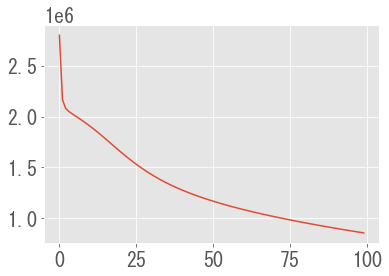

In [24]:
plt.plot(range(len(model.loss_list)), model.loss_list)

`submit`用のデータ作成．簡単なモデルを利用する．

In [151]:
path_submit = r'C:\Users\yota-\Desktop\study\mystudy\recsys\dressipi_recsys2022\submits'
df_submit.to_csv(path_submit + r"\matrix_factorization.csv", index = False)
df_submit

経過時間(実績)　= 0:07:22.354360 49901 / 50000 (99.80%)



今回の学習の結果を保存する(もう一度計算を回すのは面倒なため)

In [43]:
path_data_temp = r'C:\Users\yota-\Desktop\study\mystudy\recsys\dressipi_recsys2022\data\temp'
model.df_P.to_pickle(path_data_temp + r'\df_P_matrix_factorization_k30.pkl')
model.df_Q.to_pickle(path_data_temp + r'\df_Q_matrix_factorization_k30.pkl')

In [41]:
# 事前に値を用意している場合は，こちらを利用する．
model.df_P = pd.read_pickle(path_data_temp + r"\df_P_matrix_factorization_k30.pkl")
model.df_Q = pd.read_pickle(path_data_temp + r"\df_Q_matrix_factorization_k30.pkl")

In [42]:
model.update(alpha = 0.05, num_iteration = 30)

  0%|                                                                        | 2845/4108850 [00:00<02:24, 28449.96it/s]

t =  0 loss =  833369.7344713117


  0%|                                                                        | 2869/4108850 [00:00<02:23, 28689.48it/s]

t =  1 loss =  833543.5017797983


  0%|                                                                        | 2790/4108850 [00:00<02:27, 27899.96it/s]

t =  2 loss =  828708.4726878987


  0%|                                                                        | 3411/4108850 [00:00<02:00, 33940.83it/s]

t =  3 loss =  819673.8928399828


  0%|                                                                        | 4926/4108850 [00:00<01:23, 49259.81it/s]

t =  4 loss =  809687.6684766229


  0%|                                                                        | 3523/4108850 [00:00<01:56, 35226.59it/s]

t =  5 loss =  799817.223418323


  0%|                                                                        | 2440/4108850 [00:00<02:48, 24399.79it/s]

t =  6 loss =  790324.0483031558


  0%|                                                                        | 3022/4108850 [00:00<02:15, 30219.52it/s]

t =  7 loss =  781204.0920576731


  0%|                                                                        | 3197/4108850 [00:00<02:08, 31968.66it/s]

t =  8 loss =  772402.2374873767


  0%|                                                                        | 2727/4108850 [00:00<02:30, 27269.70it/s]

t =  9 loss =  763861.6057302599


  0%|                                                                        | 2556/4108850 [00:00<02:40, 25559.96it/s]

t =  10 loss =  755546.3732773173


  0%|                                                                        | 2483/4108850 [00:00<02:45, 24829.55it/s]

t =  11 loss =  747425.6164701172


  0%|                                                                        | 3067/4108850 [00:00<02:13, 30669.08it/s]

t =  12 loss =  739474.959008702


  0%|                                                                        | 3692/4108850 [00:00<01:51, 36919.68it/s]

t =  13 loss =  731675.3096094765


  0%|                                                                                      | 0/4108850 [00:00<?, ?it/s]

t =  14 loss =  724011.9452117633


  0%|                                                                        | 2603/4108850 [00:00<02:37, 26029.90it/s]

t =  15 loss =  716473.4089602167


  0%|                                                                        | 3487/4108850 [00:00<01:57, 34869.95it/s]

t =  16 loss =  709050.6481709585


  0%|                                                                        | 3549/4108850 [00:00<01:56, 35314.23it/s]

t =  17 loss =  701736.3842018787


  0%|                                                                        | 3348/4108850 [00:00<02:02, 33479.71it/s]

t =  18 loss =  694524.6586757796


  0%|                                                                        | 2492/4108850 [00:00<02:45, 24796.05it/s]

t =  19 loss =  687410.5074164011


  0%|                                                                        | 3382/4108850 [00:00<02:01, 33819.63it/s]

t =  20 loss =  680389.7267504731


  0%|                                                                        | 3964/4108850 [00:00<01:43, 39639.75it/s]

t =  21 loss =  673458.7059547943


  0%|                                                                        | 3400/4108850 [00:00<02:00, 33999.38it/s]

t =  22 loss =  666614.3060548261


  0%|                                                                        | 2387/4108850 [00:00<02:52, 23869.85it/s]

t =  23 loss =  659853.7704669164


  0%|                                                                        | 2692/4108850 [00:00<02:32, 26917.52it/s]

t =  24 loss =  653174.6573019857


  0%|                                                                        | 2287/4108850 [00:00<02:59, 22869.80it/s]

t =  25 loss =  646574.7863968728


  0%|                                                                        | 2042/4108850 [00:00<03:21, 20419.82it/s]

t =  26 loss =  640052.1964593226


  0%|                                                                        | 2592/4108850 [00:00<02:38, 25919.41it/s]

t =  27 loss =  633605.1094411598


  0%|                                                                        | 3294/4108850 [00:00<02:04, 32939.56it/s]

t =  28 loss =  627231.9005197991


100%|█████████████████████████████████████████████████████████████████████| 4108850/4108850 [01:13<00:00, 55762.25it/s]

t =  29 loss =  620931.0728749835
